In [2]:
# Load the CNN dailymail dataset
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version = "3.0.0")
print(f"Features: {dataset['train'].column_names}")

sample = dataset["train"][1]
print(f"""
Article: total length: {len(sample["article"])}
""")

print(sample["article"][:500])
print(sample["highlights"])

Using custom data configuration default
Reusing dataset cnn_dailymail (/home/tanvir/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']

Article: total length: 3192

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


In [9]:
# We will now compare different models with the sample_text
sample_text = dataset["train"][1]["article"][:2000]
# We will collect summaries in the following dictionary
summaries = {}

# The usual convention is to split texts with a newline. Lets load a sophisticated algo to do that
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization"
sent_tokenize(string)

# The baseline is just first three sentences of the article
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])
summaries["baseline"] = three_sentence_summary(sample_text)
print(summaries["baseline"])

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.


[nltk_data] Downloading package punkt to /home/tanvir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
# GPT-2: You just need to add TL;DR after the article an GPT-2 will generate a summary!
from transformers import pipeline, set_seed
set_seed(42)
pipe = pipeline("text-generation", model = "gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length = 512, clean_up_tokenization_spaces = True)
summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :])) 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [21]:
pipe = pipeline("summarization", model = "t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [17]:
pipe = pipeline("summarization", model = "facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [19]:
pipe = pipeline("summarization", model = "google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [20]:
# Now its time to compare the output from different models
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
Nesta, the fastest man in the world.
Gatlin, the most successful Olympian ever.
Kemar, a Jamaican legend.
Shelly-Ann, the fastest woman ever.
Bolt, the world's greatest athlete.
The team sport of pole vaulting

T5
usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .
the 26-yea

In [67]:
# Now we need to measure the quality of summaries with some metrics. We will use Rouge since its more suited for summarization tasks
from datasets import load_metric
import pandas as pd
rouge_metric = load_metric("rouge")

reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction = summaries[model_name], reference = reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index = summaries.keys())

# Lets write a function to evaluate the performance of baseline summaries and run it over the samples.
def evaluate_summaries_baseline(dataset, metric, column_text = "article", column_summary = "highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions = summaries, references = dataset[column_summary])
    score = metric.compute()
    return score

# To make everything faster, we run evaluations on a sample of 1000.
test_sampled = dataset["test"].shuffle(seed = 42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient = "index", columns = ["baseline"]).T

Loading cached shuffled indices for dataset at /home/tanvir/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234/cache-e3d7667669a9eaad.arrow


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388071,0.170554,0.247146,0.354972


In [73]:
# Lets implement the same function for evaluating pegasus model
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]
        
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size = 16, device = device, column_text = "article", column_summary = "highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total = len(article_batches)):
        inputs = tokenizer(article_batch, max_length = 1024, truncation = True, padding = "max_length", return_tensors = "pt")
        summaries = model.generate(input_ids = inputs["input_ids"].to(device), attention_mask = inputs["attention_mask"].to(device), length_penalty = 0.8, num_beams = 8, max_length = 128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True, clean_up_tokenization_spaces = True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions = decoded_summaries, references = target_batch)
    score = metric.compute()
    return score
    

# Now lets load the model again and evaluate it
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size = 8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index = ["pegasus"])
    

100%|█████████████████████████████████████████████████████████████████████████████| 125/125 [12:25<00:00,  5.96s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427255,0.207432,0.305332,0.369296


In [82]:
# Now its time to train our model on the SAMsum datatset. First lets insepct the dataset a little
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths : {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogues:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

# Lets run the pegasus model on the dataset and see how it goes
pipe = pipeline("summarization", model = "google/pegasus-cnn_dailymail")
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary with Pegasus:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

# The summary oes not look very nice. Lets confirm that by running Rouge evaluation
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text = "dialogue", column_summary = "summary", batch_size = 8)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index = ["pegasus"])

Reusing dataset samsum (/home/tanvir/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

Split lengths : [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogues:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary with Pegasus:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


100%|█████████████████████████████████████████████████████████████████████████████| 103/103 [09:09<00:00,  5.33s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.295856,0.087267,0.228962,0.229399


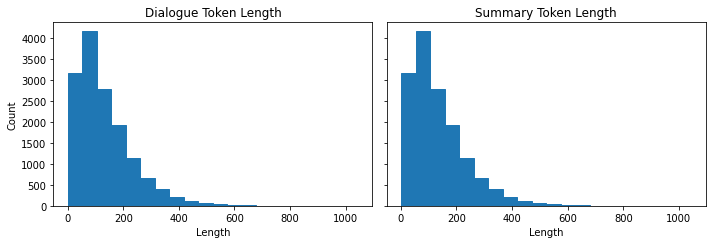

In [85]:
# Now its time to fine-tune the data. Lets take a quick look at the length distribution of inputs and outputs
import matplotlib.pyplot as plt
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize = (10, 3.5), sharey = True)
axes[0].hist(d_len, bins = 20, color = "C0", edgecolor = "C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(d_len, bins = 20, color = "C0", edgecolor = "C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [3]:
# Based on the distribution, We will set 1024 and 128 for dialogues and summaries
from datasets import load_dataset
from transformers import AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length = 1024, truncation = True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length = 128, truncation = True)
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum = load_dataset("samsum")
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type = "torch", columns = columns)

Reusing dataset samsum (/home/tanvir/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/tanvir/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-9ac948daec4efa06.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /home/tanvir/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6/cache-0a8e1695c85dcf65.arrow


In [7]:
from transformers import DataCollatorForSeq2Seq, TrainingArguments, Trainer, AutoTokenizer, AutoModelForSeq2SeqLM
from huggingface_hub import notebook_login
import torch
from datasets import load_dataset
#import os

torch.cuda.empty_cache()

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

device = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length = 1024, truncation = True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length = 128, truncation = True)
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size = 16, device = device, column_text = "article", column_summary = "highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total = len(article_batches)):
        inputs = tokenizer(article_batch, max_length = 1024, truncation = True, padding = "max_length", return_tensors = "pt")
        summaries = model.generate(input_ids = inputs["input_ids"].to(device), attention_mask = inputs["attention_mask"].to(device), length_penalty = 0.8, num_beams = 8, max_length = 128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens = True, clean_up_tokenization_spaces = True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions = decoded_summaries, references = target_batch)
    score = metric.compute()
    return score

dataset_samsum = load_dataset("samsum")
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type = "torch", columns = columns)

# Login to huggingface hub
notebook_login()

# Now we need to create a data collator. This function is called in the Trainer just before the batch is fed through the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)
training_args = TrainingArguments(
    output_dir = 'pegasus-samsum', num_train_epochs = 1, warmup_steps = 500, per_device_train_batch_size = 1, per_device_eval_batch_size = 1,
    weight_decay = 0.01, logging_steps = 10, push_to_hub = True, evaluation_strategy = 'steps', eval_steps = 500, save_steps = 1e6, gradient_accumulation_steps = 16, gradient_checkpointing=True)
trainer = Trainer(model = model, args = training_args, tokenizer = tokenizer, data_collator = seq2seq_data_collator, 
                 train_dataset = dataset_samsum_pt["train"], eval_dataset = dataset_samsum_pt["validation"])
print("Started training")
trainer.train()
print("Training done...Push to hub")
trainer.push_to_hub("Training Complete")
#trainer.push_to_hub("Training Complete")
#score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = "dialogue", column_summary = "summary")
#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
#pd.DataFrame(rouge_dict, index = ["pegasus"])

# Finally push to hub
#trainer.push_to_hub("Training Complete")


Reusing dataset samsum (/home/tanvir/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/home/tanvir/work/huggingface-starter/pegasus-samsum is already a clone of https://huggingface.co/tanviraumi/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.
The following columns in the training set  don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: summary, id, dialogue. If summary, id, dialogue are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW 

Started training


/home/tanvir/work/huggingface-starter/.env/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 15.74 GiB total capacity; 14.42 GiB already allocated; 15.94 MiB free; 14.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
from pynvml import *

def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    
print_gpu_utilization()  

custom_conversation = """\
Tanvir: Hi guys, have you heard of Highspot or sales enablement?
Kurt: No, explain it to me
Tanvir: Highspot is a company that provides sales enablement. It helps your sales people to perform sales efficiently.
Kurt: Tell me more
Tanvir: Steve can do it better
Steve: HIghpot does sales enablement by providing a content aggregation platform along with training, coaching, and engagement tools. For sales enablement, Highspot is all you need. 
"""

GPU memory occupied: 16360 MB.
